In [1]:
import os, glob, time
import cv2
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from pathlib import Path
from tqdm import tqdm
from sklearn.utils import Bunch
from skimage.io import imread
from skimage.transform import resize
from imgaug import augmenters as iaa
from termcolor import colored
from joblib import Parallel, delayed

In [2]:
data = pd.read_csv("../data/train.csv")
datadir = '../data/train_images/'

def samples(data, percent, seed=1):
    sample = data.sample(n=(round(percent*data.shape[0])), random_state=seed)
    return sample

sample = samples(data, 0.1)

num_of_samples = sample.groupby(['ClassName']).size().reset_index(name='Count')['Count']
print(list(num_of_samples))

[9, 22, 6, 21, 9, 11, 10, 9, 9, 55, 10, 28, 7, 33, 35, 15, 7, 18, 31, 3, 10, 20, 11, 16, 17, 4, 9, 7, 14, 3, 12, 7, 7, 5, 9, 17, 16, 4, 6, 11, 3, 6, 7, 33, 64, 2, 4, 8, 6, 5, 13, 14, 9, 29, 15, 96, 16, 7, 20, 16, 6]


In [3]:
def load_img_labels(datadir, data):
    image_path = []
    label = []
    
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        img = mpimg.imread(os.path.join(datadir, indexed_data['ImageId']))
        img = cv2.resize(img, (64, 64))
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        image_path.append(img)
        label.append(indexed_data['ClassName'])
    image_path = np.asarray(image_path)
    label = np.asarray(label)
    return image_path, label

image_path, label = load_img_labels(datadir, sample)

print(image_path.shape)


# image_path = image_path.reshape((len(image_path), -1))
# print(image_path.shape)

(932, 64, 64, 3)


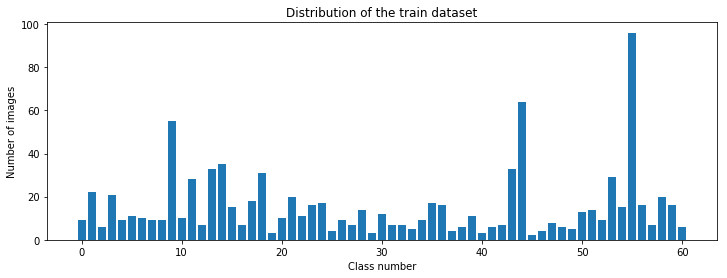

In [4]:
plt.figure(figsize=(12, 4))
plt.bar(range(0, len(list(num_of_samples))), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

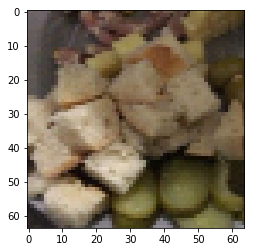

In [5]:
original_image = image_path[10]
plt.imshow(original_image)

(64, 64)


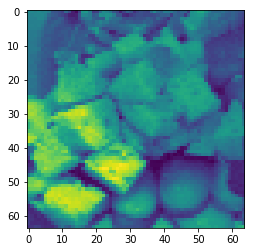

In [6]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img
img = grayscale(original_image)
plt.imshow(img)
print(img.shape)

In [7]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

(64, 64)


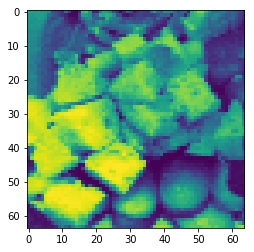

In [8]:
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img / 255
    return img
img = preprocessing(original_image)
plt.imshow(img)
print(img.shape)

In [9]:
def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image

Text(0.5, 1.0, 'Zoomed Image')

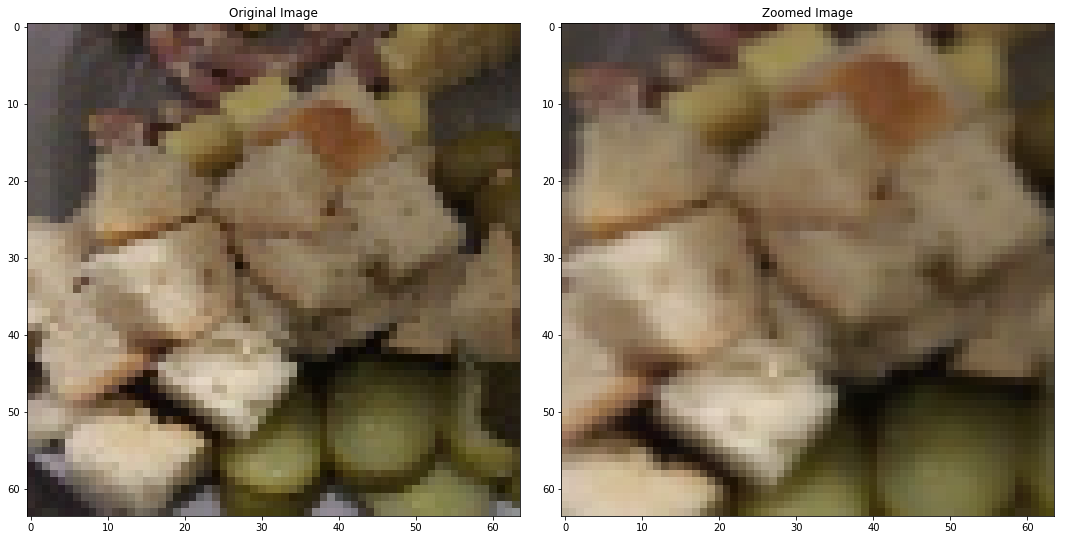

In [10]:
zoomed_image = zoom(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [11]:
def pan(image):
    pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

Text(0.5, 1.0, 'Panned Image')

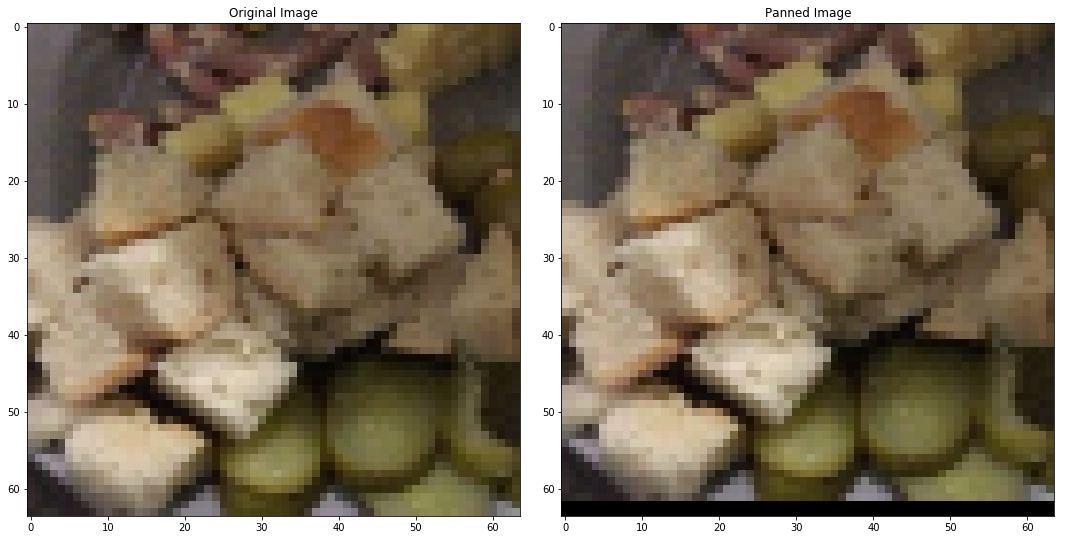

In [12]:
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

In [13]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

Text(0.5, 1.0, 'Brightness altered image ')

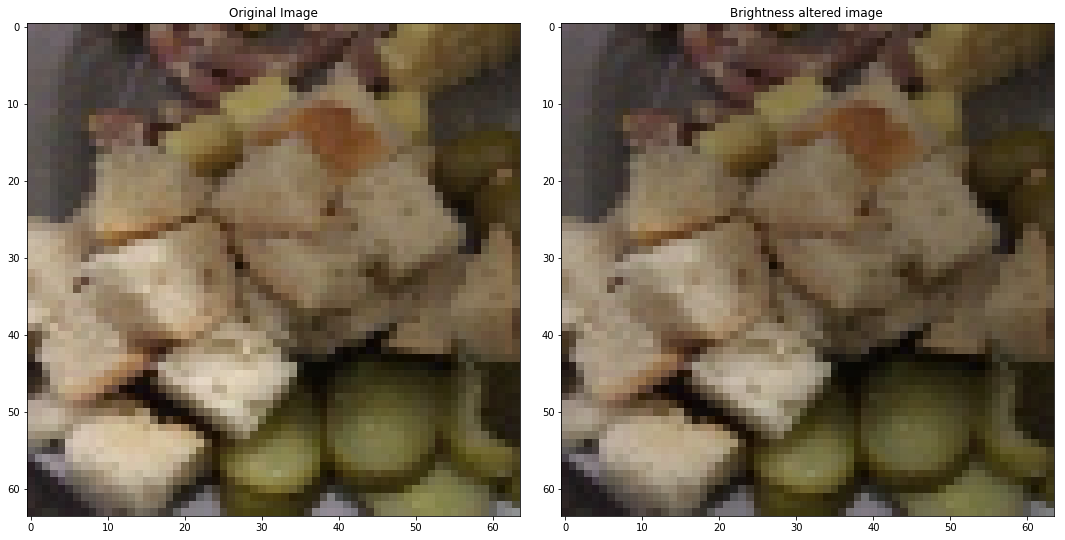

In [14]:
brightness_altered_image = img_random_brightness(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

In [15]:
def random_augment(image):
    
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = img_random_brightness(image)
#     image = preprocessing(image)
    return image

In [16]:
random_augment(original_image).shape

(64, 64, 3)

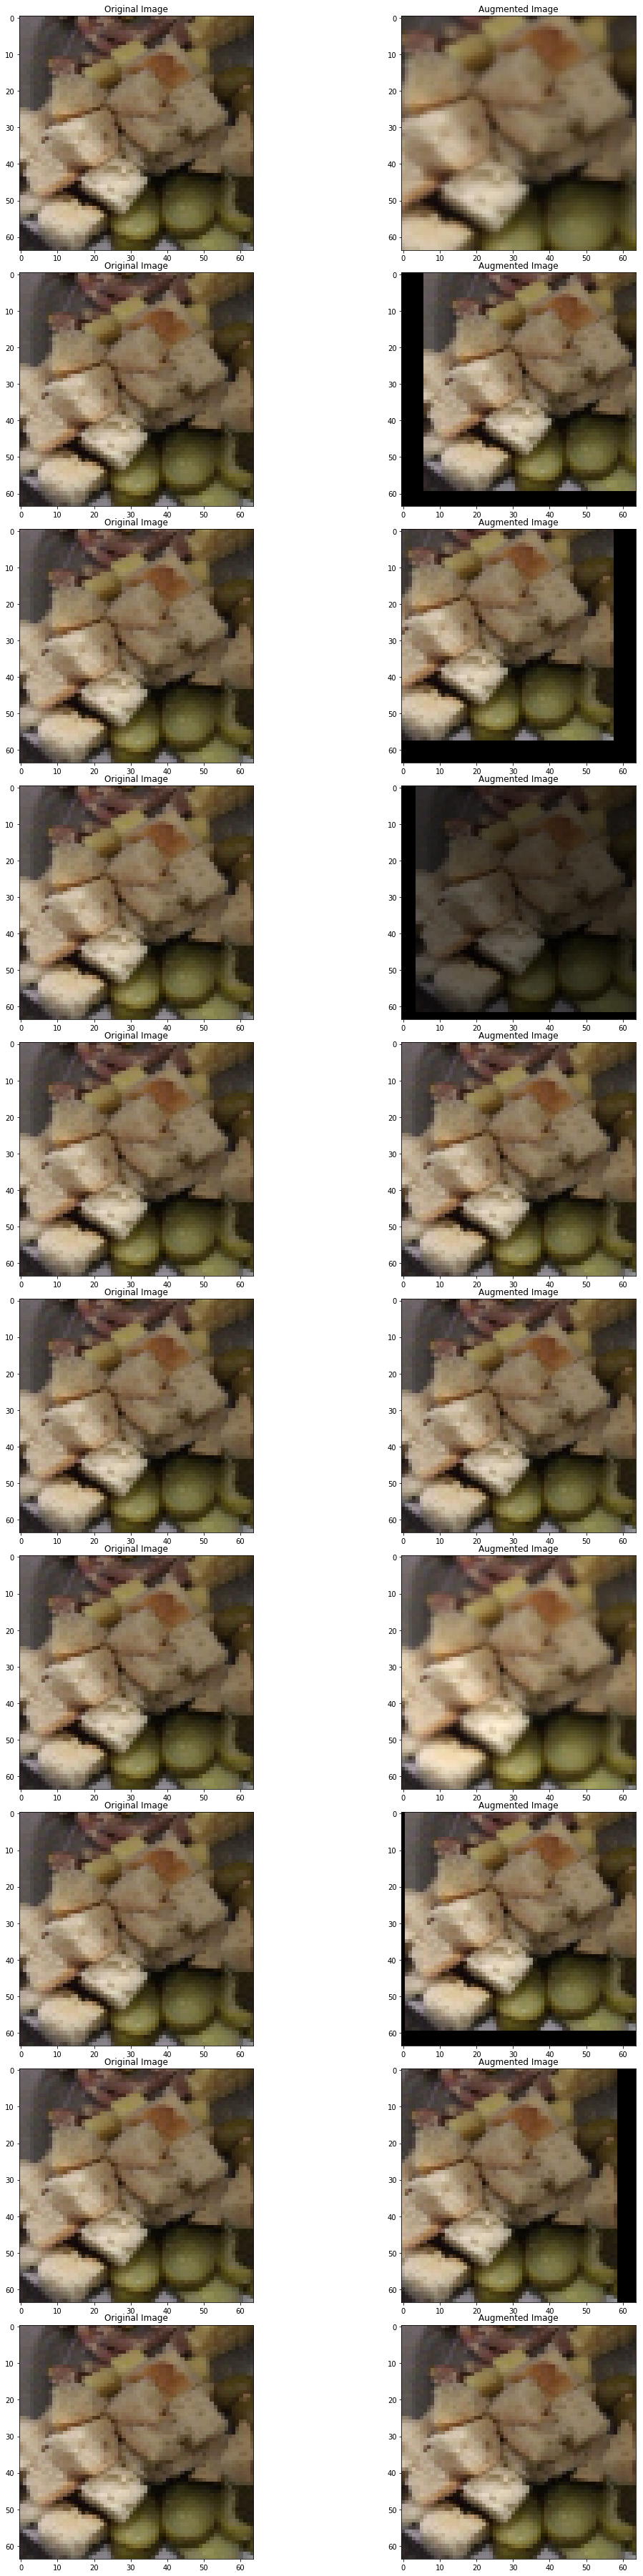

In [17]:
ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
    augmented_image = random_augment(original_image)
     
    axs[i][0].imshow(original_image)
    axs[i][0].set_title("Original Image")
  
    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title("Augmented Image")

In [18]:
X = np.array(list(map(preprocessing, image_path)))


In [19]:
X.shape

(932, 64, 64)

In [20]:
from sklearn.model_selection import train_test_split

seed = 1
X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.2, random_state=seed)

print("X_train.shape :",X_train.shape)
print("X_test.shape  :",X_test.shape)
print("y_train.shape :",y_train.shape)
print("y_test.shape  :",y_test.shape)

X_train.shape : (745, 64, 64)
X_test.shape  : (187, 64, 64)
y_train.shape : (745,)
y_test.shape  : (187,)


In [21]:
def generate(images, count):
    generated = []
    while True:
        for image in images:
            if len(generated) == count:
                return generated
            image = random_augment(image)
            generated.append(np.expand_dims(image, axis=2))

In [22]:
# unique, counts = np.unique(y_train, return_counts=True)
# # print(unique, counts)
# # print(list(zip(unique, counts)))
# # target = max(num_of_samples)
# # x_augmented = []
# # y_augmented = []

# def multiprocess(cls, count, target, x_augmented, y_augmented):
#     print(cls)
#     diff = target - count
#     x_augmented += generate(X_train[np.where(y_train == cls)[0]], diff)
#     y_augmented += [cls for _ in range(diff)]
#     return x_augmented, y_augmented

# result = Parallel(n_jobs=-1)(
#             delayed(multiprocess)
#                     (cls, count, max(num_of_samples), x_augmented = [], y_augmented = []) 
#             for cls, count in tqdm(list(zip(unique, counts)), 'Augmenting training dataset'))

In [23]:
# len(result[0][1])

In [24]:
unique, counts = np.unique(y_train, return_counts=True)
# print(unique, counts)

target = max(num_of_samples)
x_augmented = []
y_augmented = []

for cls, count in tqdm(list(zip(unique, counts)), 'Augmenting training dataset'):
#     print(cls)
#     print(count)
    diff = target - count
#     print(diff, target, count)
    x_augmented += generate(X_train[np.where(y_train == cls)[0]], diff)
    y_augmented += [cls for _ in range(diff)]

Augmenting training dataset: 100%|██████████| 61/61 [00:14<00:00,  4.28it/s]


In [25]:
print(max(list(num_of_samples)))

96


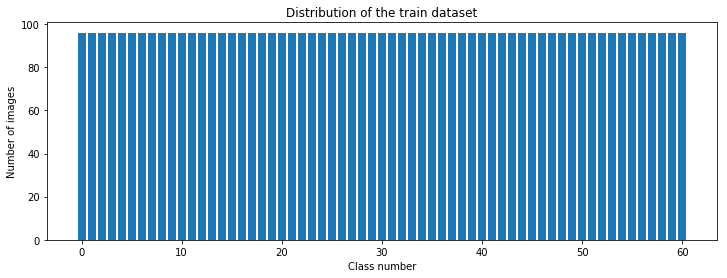

In [26]:
plt.figure(figsize=(12, 4))
plt.bar(range(0, 61), target)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [27]:
# print(np.asarray(x_augmented).shape)
print(X_train.shape)
print(X_test.shape)
print(np.array(x_augmented).shape)
X_train = X_train.reshape(X_train.shape[0], 64, 64, 1)
X_test = X_test.reshape(X_test.shape[0], 64, 64, 1)
x_train = np.concatenate([X_train, np.array(x_augmented)])
y_train = np.concatenate([y_train, np.array(y_augmented)])
n_train = y_train.size
print('Final number of training samples', n_train)
print(x_train.shape)
print(y_train.shape)

(745, 64, 64)
(187, 64, 64)
(5111, 64, 64, 1)
Final number of training samples 5856
(5856, 64, 64, 1)
(5856,)


In [33]:
x_train = x_train.reshape((len(x_train), -1))
x_test = X_test.reshape((len(X_test), -1))

print(x_train.shape)
print(x_test.shape)

(5856, 4096)
(187, 4096)


In [34]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, log_loss, make_scorer, r2_score, mean_squared_error, f1_score, precision_score, jaccard_score, recall_score, roc_auc_score

startTrain = time.perf_counter()
clf = SVC(gamma=0.001)
clf.fit(x_train, y_train)
endTrain = time.perf_counter()
print("time for training took {}s \n".format(colored(endTrain-startTrain, "red")))

time for training took 233.92492625699379s 



In [36]:
print("\n================================================================")
print("================================================================")
# print(colored("best params: " + str(clf.best_params_), "blue"))
# print(colored("best scores: " + str(clf.best_score_), "cyan"))
# estimates = clf.predict_proba(X_test)

y_pred = clf.predict(x_test)
acc = accuracy_score(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)
#f1 = f1_score(y_test, y_pred)
#precisionScore = precision_score(y_test, y_pred)
#jaccardScore = jaccard_score(y_test, y_pred)
#recallScore = recall_score(y_test, y_pred)
#rocAucScore =  roc_auc_score(y_test, y_pred)


print("--------------------------------")
print("Accuracy: {:.4%}".format(acc))
#print("F1 : {:.4%}".format(f1))
# print("MSE : {:.4%}".format(mse))
# print("RMSE : {:.4%}".format(rmse))
#print("precision_score : {:.4%}".format(precisionScore))
#print("jaccard_score : {:.4%}".format(jaccardScore))
#print("recall_score : {:.4%}".format(recallScore))
#print("roc_auc_score : {:.4%}".format(rocAucScore))
# print("R2 : {:.4%}".format(r2))
print("--------------------------------\n")
print("================================================================")
print("================================================================\n")


--------------------------------
Accuracy: 5.3476%
--------------------------------




(187, 2)


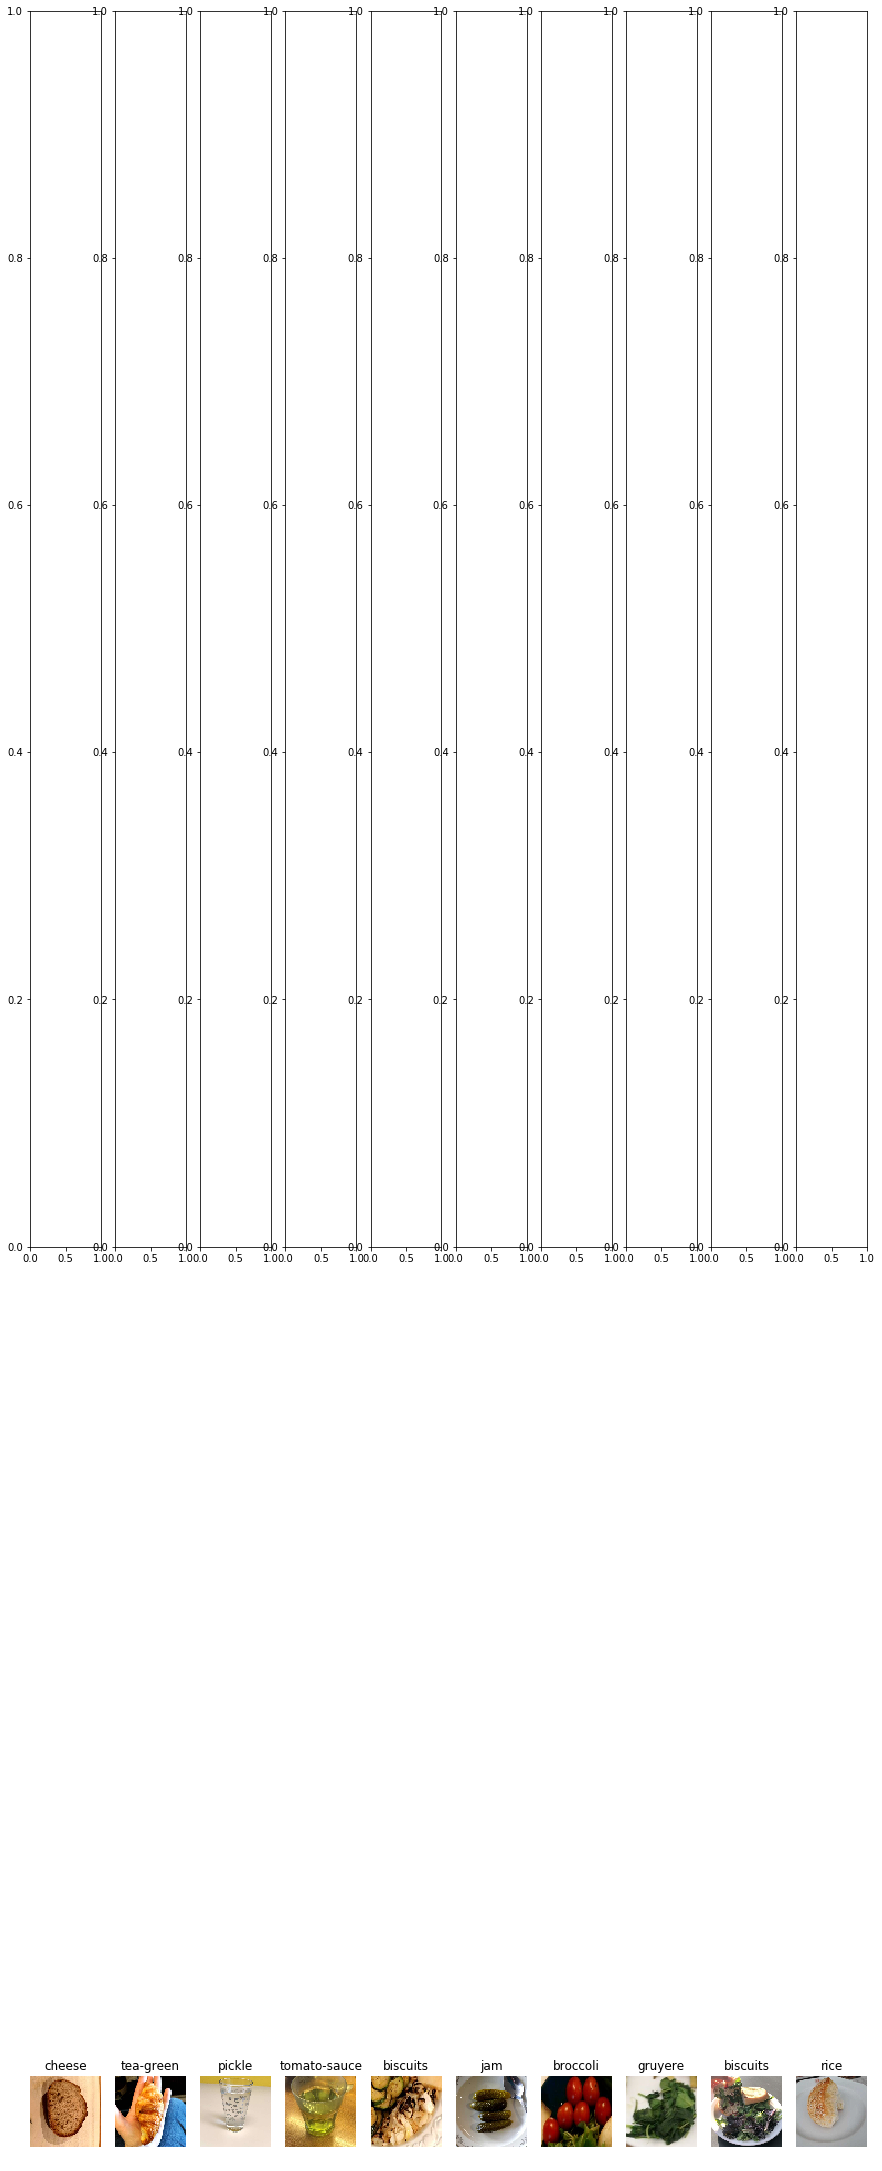

In [38]:
predicted = clf.predict(x_test)
#print(predicted)
#exit()
_, axes = plt.subplots(2, 10, figsize=(15, 50))
images_and_predictions = list(zip(image_path[len(image_path) // 2:], predicted))
print(np.asarray(images_and_predictions).shape)
# images_and_predictions[100]
for ax, (image, prediction) in zip(axes[1, :], images_and_predictions[:]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(prediction)